In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow_hub as hub
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import seaborn as sns
from sklearn.model_selection import KFold
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

In [2]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

In [3]:
# Tải mô hình Faster R-CNN từ PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detector = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
detector.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 206MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
# Đường dẫn dữ liệu gốc và thư mục lưu ảnh cắt
base_dir = "/kaggle/input/cs114-ml"
dataset_dir = os.path.join(base_dir, "dataset")
cropped_images_dir = "/kaggle/working/cropped_images"
os.makedirs(cropped_images_dir, exist_ok=True)

In [5]:
# Đường dẫn file CSV chứa lỗi ảnh
error_csv_path = os.path.join(base_dir, "ImageErrors.csv")
error_paths = pd.read_csv(error_csv_path).iloc[:, 0].tolist()  # Danh sách ảnh lỗi

In [6]:
# Chọn thiết bị (GPU nếu có, ngược lại sử dụng CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detector = detector.to(device)  # Đưa mô hình lên thiết bị

In [7]:
def crop_and_save(image_path, class_name):
    """
    Cắt và lưu ảnh dựa trên bounding box từ mô hình Faster R-CNN.
    Nếu không phát hiện bounding box, lưu lại ảnh gốc.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load {image_path}")
        return

    # Chuyển đổi ảnh sang RGB và chuẩn hóa
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.tensor(image_rgb).permute(2, 0, 1).float().unsqueeze(0).to(device)

    # Dự đoán bounding box
    with torch.no_grad():
        result = detector(image_tensor)
    boxes = result[0]['boxes'].cpu().detach().numpy()  # Bounding box
    scores = result[0]['scores'].cpu().detach().numpy()  # Confidence
    labels = result[0]['labels'].cpu().detach().numpy()  # Class labels

    # Kiểm tra nếu không có bounding box nào
    if len(scores) == 0 or len(boxes) == 0:
        print(f"No bounding boxes found for {image_path}. Saving original image.")
        cropped_image = image
    else:
        # Ưu tiên bounding box lớn nhất có confidence > threshold
        max_area = 0
        prioritized_box = None
        for i, (box, score) in enumerate(zip(boxes, scores)):
            if score < 0.5:  # Ngưỡng confidence
                continue
            xmin, ymin, xmax, ymax = box.astype(int)
            area = (xmax - xmin) * (ymax - ymin)
            if area > max_area:
                max_area = area
                prioritized_box = (xmin, ymin, xmax, ymax)

        # Nếu có bounding box đạt ngưỡng
        if prioritized_box:
            xmin, ymin, xmax, ymax = prioritized_box
            cropped_image = image[ymin:ymax, xmin:xmax]
        else:
            print(f"No bounding boxes above confidence threshold for {image_path}. Saving original image.")
            cropped_image = image

    # Lưu ảnh (cả cắt hoặc gốc nếu không phát hiện bounding box)
    class_dir = os.path.join(cropped_images_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Đảm bảo tên file có đuôi mở rộng
    image_name = os.path.basename(image_path)
    if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
        image_name += ".jpg"  # Mặc định lưu dưới dạng JPEG

    cropped_image_path = os.path.join(class_dir, image_name)
    cv2.imwrite(cropped_image_path, cropped_image)

In [8]:
def process_dataset(dataset_dir, error_paths):
    """
    Lọc ảnh lỗi và thực hiện cắt ảnh từ dataset gốc.
    """
    print("Processing dataset...")
    for class_name in tqdm(os.listdir(dataset_dir)):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Bỏ qua ảnh lỗi
            if image_path in error_paths:
                continue

            # Cắt và lưu ảnh
            crop_and_save(image_path, class_name)

    print(f"Processing completed! Cropped images saved at: {cropped_images_dir}")


# Thực hiện cắt ảnh
process_dataset(dataset_dir, error_paths)

Processing dataset...


  0%|          | 0/9 [00:00<?, ?it/s]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/22521070-22520211.Hyundai.238.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Hyundai/22521342-22520970.Hyundai.34.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/22520394-22520395.Hyundai.117.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Hyundai/22521070-22520211.Hyundai.348.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/21520930-21522924.Huyndai.31-.png. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/22521463-22521213-22521259.Hyundai.1.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/22520394-22520395.Hyundai.46.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Hyundai/22521070-22

 11%|█         | 1/9 [06:06<48:49, 366.22s/it]

No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Honda/22521027-22520195-22521060.Honda.920.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521027-22520195-22521060.Honda.252.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22520914-22520915.Honda.5.png. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521027-22520195-22521060.Honda.779.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521027-22520195-22521060.Honda.190.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521027-22520195-22521060.Honda.325.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521692-22521676.Honda.21.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Honda/22521692-22521676.Honda.1

 22%|██▏       | 2/9 [10:55<37:26, 321.00s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/22521342-22520970.VinFast.65.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/21520930-21522924.VinFast.79-.png. Saving original image.
Error: Unable to load /kaggle/input/cs114-ml/dataset/VinFast/22521692-22521676.VinFast.18.jpg
No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/22521027-22520195-22521060.VinFast.0058.jpg. Saving original image.
Error: Unable to load /kaggle/input/cs114-ml/dataset/VinFast/22521692-22521676.VinFast.17.jpg
No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/21522924.VinFast.79.png. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/22521027-22520195-22521060.VinFast.0050.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/VinFast/22521027-22520195-22521060.VinFast.0974.jpg. Saving original image.
No bounding boxes found for /kaggle/input/c

 33%|███▎      | 3/9 [15:52<31:00, 310.04s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.394.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.366.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.442.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.289.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.324.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.415.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/KIA/22521027-22520195-22521060.KIA.170.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/KIA/22521027-2252

 44%|████▍     | 4/9 [21:20<26:26, 317.21s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/22521342-22520970.Toyota.97.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/22521027-22520195-22521060.Toyota.1798.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/22521692-22521676.Toyota.129.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/21520938-22520634.Toyota.358.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Toyota/21520930-21522924.Toyota.65-.png. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/22520550-22520967.Toyota.7.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Toyota/21520938-22520634.Toyota.666.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Toyota/22521692-22521676.Toyota

 56%|█████▌    | 5/9 [30:09<26:13, 393.45s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Suzuki/22521070-22520211.Suzuki.127.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Suzuki/22521342-22520970.Suzuki.249.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Suzuki/22521027-22520195-22521060.Suzuki.0824.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Suzuki/22521027-22520195-22521060.Suzuki.1513.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Suzuki/22521492-22521599.Suzuki.8.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Suzuki/22520459-22520507-22520862.Suzuki.130.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Suzuki/22521027-22520195-22521060.Suzuki.0948.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/S

 67%|██████▋   | 6/9 [39:22<22:22, 447.57s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mitsubishi/22521692-22521676.Mitsubishi.116.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mitsubishi/22521027-22520195-22521060.Mitsubishi.118.jpg. Saving original image.
Error: Unable to load /kaggle/input/cs114-ml/dataset/Mitsubishi/22520348-22520530-22520837.Mitsubishi.18.jpg
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mitsubishi/22521342-22520970.Mitsubishi.122.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Mitsubishi/22521027-22520195-22521060.Mitsubishi.672.jpg. Saving original image.
Error: Unable to load /kaggle/input/cs114-ml/dataset/Mitsubishi/22521463-22521213-22521259.Mitsubishi.76.jpg
Error: Unable to load /kaggle/input/cs114-ml/dataset/Mitsubishi/22521463-22521213-22521259.Mitsubishi.57.jpg
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mitsubishi/22521692-22521676.Mitsubishi.119.jpg. Sa

 78%|███████▊  | 7/9 [45:17<13:55, 417.53s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/21522373-21522499.Mazda.37.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/22521692-22521676.Mazda.93.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/22521027-22520195-22521060.Mazda.928.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/22521692-22521676.Mazda.25.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/22521692-22521676.Mazda.49.jpg. Saving original image.
No bounding boxes found for /kaggle/input/cs114-ml/dataset/Mazda/22521692-22521676.Mazda.76.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Mazda/22521586-22521559.Mazda.227.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Mazda/22521692-22521676.Mazda.29.jpg. Saving ori

 89%|████████▉ | 8/9 [51:19<06:39, 399.63s/it]

No bounding boxes found for /kaggle/input/cs114-ml/dataset/Others/22520394-22520395.Others.107.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Others/22520394-22520395.Others.384.jpg. Saving original image.
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Others/22520394-22520395.Others.95.jpg. Saving original image.
Error: Unable to load /kaggle/input/cs114-ml/dataset/Others/22520477-22520490.Others.4.jpg
Error: Unable to load /kaggle/input/cs114-ml/dataset/Others/22520477-22520490.Others.3.jpg
Error: Unable to load /kaggle/input/cs114-ml/dataset/Others/22520477-22520490.Others.7.jpg
Error: Unable to load /kaggle/input/cs114-ml/dataset/Others/22520348-22520530-22520837.Maybach.2.jpg
Error: Unable to load /kaggle/input/cs114-ml/dataset/Others/22520477-22520490.Others.10.jpg
No bounding boxes above confidence threshold for /kaggle/input/cs114-ml/dataset/Others/22520394-22520395.Others.170.jpg. Sav

100%|██████████| 9/9 [59:14<00:00, 394.94s/it]

Processing completed! Cropped images saved at: /kaggle/working/cropped_images


In [9]:
def split_data(cropped_images_dir, num_folds=5):
    """
    Chia dữ liệu đã cắt thành 5 fold cho Cross-Validation.
    """
    all_images = []
    all_labels = []

    for class_name in os.listdir(cropped_images_dir):
        class_dir = os.path.join(cropped_images_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            all_images.append(image_path)
            all_labels.append(class_name)

    # KFold Cross Validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    folds = []

    for train_idx, test_idx in kf.split(all_images):
        train_images = [all_images[i] for i in train_idx]
        train_labels = [all_labels[i] for i in train_idx]
        test_images = [all_images[i] for i in test_idx]
        test_labels = [all_labels[i] for i in test_idx]
        folds.append((train_images, train_labels, test_images, test_labels))

    print(f"Data split into {num_folds} folds.")
    return folds

# Chia dữ liệu
folds = split_data(cropped_images_dir)

Data split into 5 folds.


In [10]:
def prepare_fold_data(fold_data, validation_split=0.2):
    """
    Chia dữ liệu train thành train và validation.
    """
    train_images, train_labels = fold_data[0], fold_data[1]

    train_X, val_X, train_Y, val_Y = train_test_split(
        train_images, train_labels, test_size=validation_split, random_state=42
    )

    print("Fold data prepared:")
    print(f"- Training: {len(train_X)} samples")
    print(f"- Validation: {len(val_X)} samples")
    print(f"- Test: {len(fold_data[2])} samples")

    return train_X, train_Y, val_X, val_Y, fold_data[2], fold_data[3]

# Chuẩn bị dữ liệu cho fold đầu tiên
train_X, train_Y, val_X, val_Y, test_X, test_Y = prepare_fold_data(folds[0])

Fold data prepared:
- Training: 24325 samples
- Validation: 6082 samples
- Test: 7602 samples


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, class_names, transform=None):
        """
        image_paths: Danh sách đường dẫn ảnh.
        class_names: Danh sách tên lớp (tương ứng với image_paths).
        transform: Các phép biến đổi áp dụng lên ảnh.
        """
        self.image_paths = image_paths
        self.class_names = class_names
        self.transform = transform

    def __getitem__(self, idx):
        # Đọc ảnh từ đường dẫn
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Đảm bảo ảnh có dạng RGB

        # Ánh xạ tên lớp thành nhãn số
        class_name = self.class_names[idx]
        label = labels[class_name]  # Sử dụng mapping để lấy nhãn

        if self.transform:
            image = self.transform(image)  # Áp dụng transform vào ảnh

        return image, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.image_paths)

In [12]:
# Khởi tạo mô hình ResNet-152
def create_resnet152_model(num_classes):
    model = models.resnet152(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [13]:
# Hàm huấn luyện và đánh giá một fold
def train_and_evaluate_fold(fold_idx, train_X, train_Y, val_X, val_Y, test_X, test_Y, num_classes=9, epochs=10, batch_size=32, save_dir="best_models"):
    # Chuẩn bị DataLoader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = CustomDataset(train_X, train_Y, transform=transform)
    val_dataset = CustomDataset(val_X, val_Y, transform=transform)
    test_dataset = CustomDataset(test_X, test_Y, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Tạo mô hình
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_resnet152_model(num_classes)
    model.to(device)

    # Loss và optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Biến lưu loss và accuracy
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0
    best_model_path = os.path.join(save_dir, f"best_model_fold_{fold_idx}.pth")
    os.makedirs(save_dir, exist_ok=True)

    # Huấn luyện
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in tqdm(train_loader, desc=f"Fold {fold_idx} Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}")

        # Lưu mô hình nếu đạt accuracy tốt nhất
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model for Fold {fold_idx} at Epoch {epoch+1} with Val Acc = {best_val_acc:.4f}")

    # Đánh giá trên tập test
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    test_accuracy = test_correct / len(test_loader.dataset)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold_idx} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.title(f"Fold {fold_idx} Accuracy")
    plt.legend()

    plt.show()

    return test_accuracy, best_model_path


Fold data prepared:
- Training: 24325 samples
- Validation: 6082 samples
- Test: 7602 samples


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 199MB/s]
Fold 1 Epoch 1/10: 100%|██████████| 761/761 [09:44<00:00,  1.30it/s]


Epoch 1: Train Loss = 1.0079, Train Acc = 0.6569, Val Loss = 0.7447, Val Acc = 0.7494
Saved best model for Fold 1 at Epoch 1 with Val Acc = 0.7494


Fold 1 Epoch 2/10: 100%|██████████| 761/761 [09:38<00:00,  1.32it/s]


Epoch 2: Train Loss = 0.4747, Train Acc = 0.8443, Val Loss = 0.6329, Val Acc = 0.8007
Saved best model for Fold 1 at Epoch 2 with Val Acc = 0.8007


Fold 1 Epoch 3/10: 100%|██████████| 761/761 [09:32<00:00,  1.33it/s]


Epoch 3: Train Loss = 0.2638, Train Acc = 0.9172, Val Loss = 0.6743, Val Acc = 0.7917


Fold 1 Epoch 4/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 4: Train Loss = 0.1713, Train Acc = 0.9463, Val Loss = 0.6973, Val Acc = 0.8009
Saved best model for Fold 1 at Epoch 4 with Val Acc = 0.8009


Fold 1 Epoch 5/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 5: Train Loss = 0.1248, Train Acc = 0.9591, Val Loss = 0.7371, Val Acc = 0.8152
Saved best model for Fold 1 at Epoch 5 with Val Acc = 0.8152


Fold 1 Epoch 6/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 6: Train Loss = 0.1119, Train Acc = 0.9642, Val Loss = 0.7950, Val Acc = 0.7997


Fold 1 Epoch 7/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 7: Train Loss = 0.0962, Train Acc = 0.9689, Val Loss = 0.6877, Val Acc = 0.8280
Saved best model for Fold 1 at Epoch 7 with Val Acc = 0.8280


Fold 1 Epoch 8/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 8: Train Loss = 0.0809, Train Acc = 0.9747, Val Loss = 0.7815, Val Acc = 0.8116


Fold 1 Epoch 9/10: 100%|██████████| 761/761 [09:32<00:00,  1.33it/s]


Epoch 9: Train Loss = 0.0938, Train Acc = 0.9697, Val Loss = 0.7369, Val Acc = 0.8206


Fold 1 Epoch 10/10: 100%|██████████| 761/761 [09:35<00:00,  1.32it/s]


Epoch 10: Train Loss = 0.0638, Train Acc = 0.9801, Val Loss = 0.7856, Val Acc = 0.8096


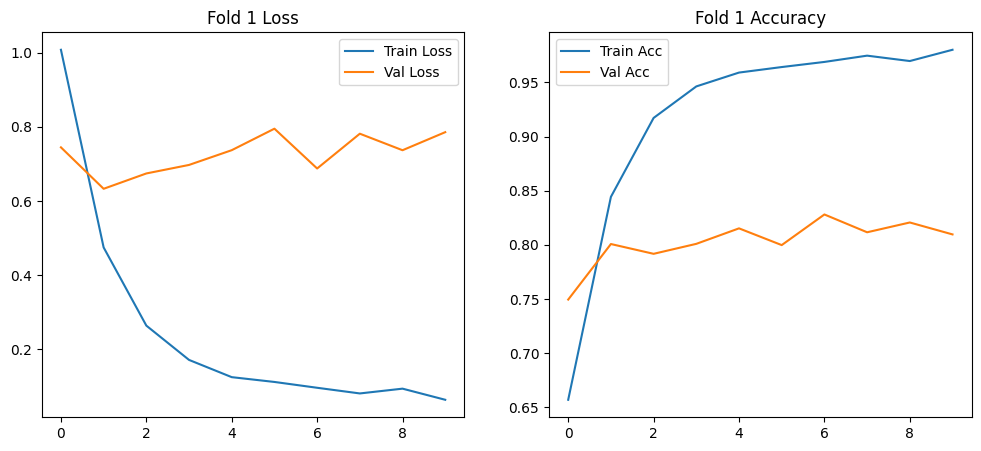

Fold 1 Test Accuracy: 0.8103
Fold data prepared:
- Training: 24325 samples
- Validation: 6082 samples
- Test: 7602 samples


Fold 2 Epoch 1/10: 100%|██████████| 761/761 [09:32<00:00,  1.33it/s]


Epoch 1: Train Loss = 0.9929, Train Acc = 0.6654, Val Loss = 0.7798, Val Acc = 0.7433
Saved best model for Fold 2 at Epoch 1 with Val Acc = 0.7433


Fold 2 Epoch 2/10: 100%|██████████| 761/761 [09:38<00:00,  1.32it/s]


Epoch 2: Train Loss = 0.4623, Train Acc = 0.8516, Val Loss = 0.6437, Val Acc = 0.7846
Saved best model for Fold 2 at Epoch 2 with Val Acc = 0.7846


Fold 2 Epoch 3/10: 100%|██████████| 761/761 [09:38<00:00,  1.32it/s]


Epoch 3: Train Loss = 0.2505, Train Acc = 0.9194, Val Loss = 0.6688, Val Acc = 0.8006
Saved best model for Fold 2 at Epoch 3 with Val Acc = 0.8006


Fold 2 Epoch 4/10: 100%|██████████| 761/761 [09:34<00:00,  1.32it/s]


Epoch 4: Train Loss = 0.1670, Train Acc = 0.9457, Val Loss = 0.6965, Val Acc = 0.8034
Saved best model for Fold 2 at Epoch 4 with Val Acc = 0.8034


Fold 2 Epoch 5/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 5: Train Loss = 0.1252, Train Acc = 0.9613, Val Loss = 0.7413, Val Acc = 0.8068
Saved best model for Fold 2 at Epoch 5 with Val Acc = 0.8068


Fold 2 Epoch 6/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 6: Train Loss = 0.1065, Train Acc = 0.9650, Val Loss = 0.7994, Val Acc = 0.8007


Fold 2 Epoch 7/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 7: Train Loss = 0.0993, Train Acc = 0.9692, Val Loss = 0.7729, Val Acc = 0.8029


Fold 2 Epoch 8/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 8: Train Loss = 0.0742, Train Acc = 0.9771, Val Loss = 0.8045, Val Acc = 0.8034


Fold 2 Epoch 9/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 9: Train Loss = 0.0851, Train Acc = 0.9726, Val Loss = 0.8364, Val Acc = 0.7969


Fold 2 Epoch 10/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 10: Train Loss = 0.0698, Train Acc = 0.9780, Val Loss = 0.8412, Val Acc = 0.7997


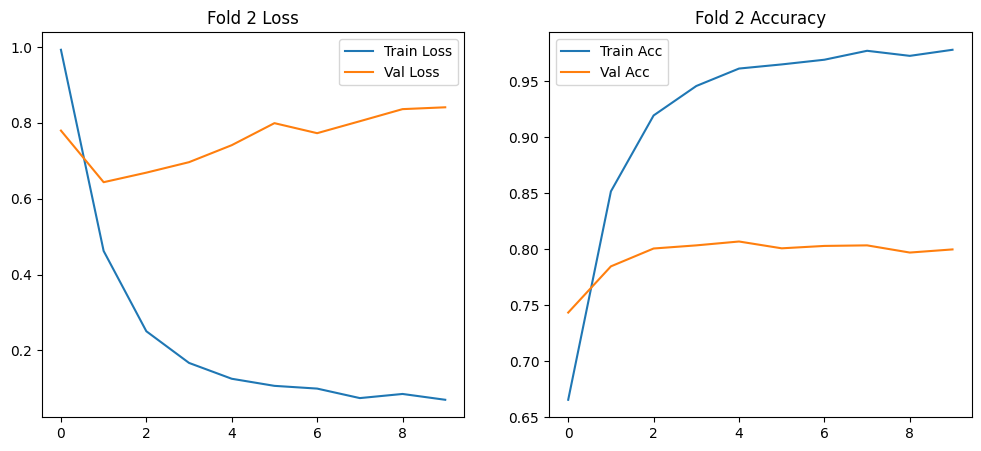

Fold 2 Test Accuracy: 0.8144
Fold data prepared:
- Training: 24325 samples
- Validation: 6082 samples
- Test: 7602 samples


Fold 3 Epoch 1/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 1: Train Loss = 0.9962, Train Acc = 0.6627, Val Loss = 0.6968, Val Acc = 0.7706
Saved best model for Fold 3 at Epoch 1 with Val Acc = 0.7706


Fold 3 Epoch 2/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 2: Train Loss = 0.4553, Train Acc = 0.8527, Val Loss = 0.6114, Val Acc = 0.8099
Saved best model for Fold 3 at Epoch 2 with Val Acc = 0.8099


Fold 3 Epoch 3/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 3: Train Loss = 0.2425, Train Acc = 0.9219, Val Loss = 0.7734, Val Acc = 0.7805


Fold 3 Epoch 4/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 4: Train Loss = 0.1717, Train Acc = 0.9450, Val Loss = 0.7541, Val Acc = 0.7907


Fold 3 Epoch 5/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 5: Train Loss = 0.1279, Train Acc = 0.9572, Val Loss = 0.7397, Val Acc = 0.8011


Fold 3 Epoch 6/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 6: Train Loss = 0.1051, Train Acc = 0.9665, Val Loss = 0.7280, Val Acc = 0.8137
Saved best model for Fold 3 at Epoch 6 with Val Acc = 0.8137


Fold 3 Epoch 7/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 7: Train Loss = 0.0982, Train Acc = 0.9677, Val Loss = 0.8143, Val Acc = 0.7960


Fold 3 Epoch 8/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 8: Train Loss = 0.0952, Train Acc = 0.9700, Val Loss = 0.7548, Val Acc = 0.8137


Fold 3 Epoch 9/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 9: Train Loss = 0.0698, Train Acc = 0.9784, Val Loss = 0.7832, Val Acc = 0.8085


Fold 3 Epoch 10/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 10: Train Loss = 0.0716, Train Acc = 0.9765, Val Loss = 0.7661, Val Acc = 0.8170
Saved best model for Fold 3 at Epoch 10 with Val Acc = 0.8170


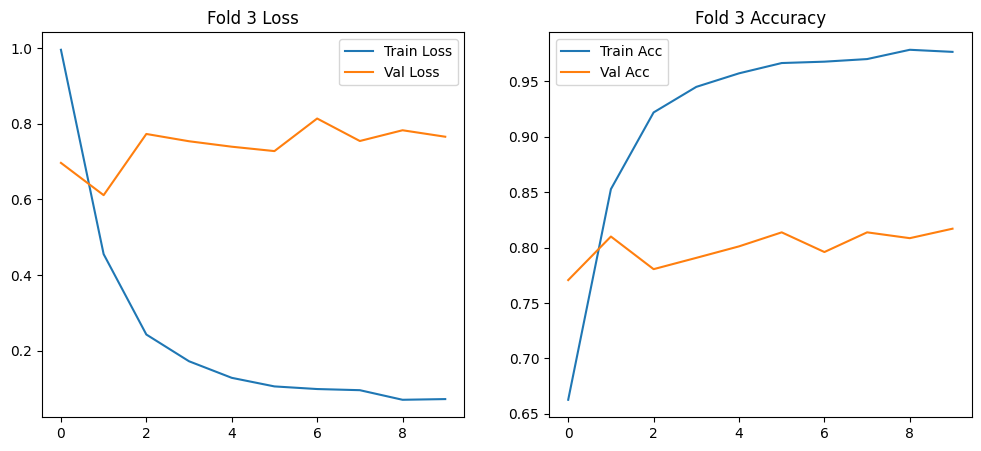

Fold 3 Test Accuracy: 0.8236
Fold data prepared:
- Training: 24325 samples
- Validation: 6082 samples
- Test: 7602 samples


Fold 4 Epoch 1/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 1: Train Loss = 1.0029, Train Acc = 0.6627, Val Loss = 0.6930, Val Acc = 0.7660
Saved best model for Fold 4 at Epoch 1 with Val Acc = 0.7660


Fold 4 Epoch 2/10: 100%|██████████| 761/761 [09:25<00:00,  1.34it/s]


Epoch 2: Train Loss = 0.4624, Train Acc = 0.8519, Val Loss = 0.6167, Val Acc = 0.7988
Saved best model for Fold 4 at Epoch 2 with Val Acc = 0.7988


Fold 4 Epoch 3/10: 100%|██████████| 761/761 [09:25<00:00,  1.35it/s]


Epoch 3: Train Loss = 0.2479, Train Acc = 0.9197, Val Loss = 0.6150, Val Acc = 0.8086
Saved best model for Fold 4 at Epoch 3 with Val Acc = 0.8086


Fold 4 Epoch 4/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 4: Train Loss = 0.1641, Train Acc = 0.9476, Val Loss = 0.7468, Val Acc = 0.7887


Fold 4 Epoch 5/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 5: Train Loss = 0.1337, Train Acc = 0.9550, Val Loss = 0.9017, Val Acc = 0.7724


Fold 4 Epoch 6/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 6: Train Loss = 0.1089, Train Acc = 0.9661, Val Loss = 0.6818, Val Acc = 0.8205
Saved best model for Fold 4 at Epoch 6 with Val Acc = 0.8205


Fold 4 Epoch 7/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 7: Train Loss = 0.0930, Train Acc = 0.9693, Val Loss = 0.7726, Val Acc = 0.8053


Fold 4 Epoch 8/10: 100%|██████████| 761/761 [09:26<00:00,  1.34it/s]


Epoch 8: Train Loss = 0.0774, Train Acc = 0.9750, Val Loss = 0.8081, Val Acc = 0.8132


Fold 4 Epoch 9/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 9: Train Loss = 0.0809, Train Acc = 0.9741, Val Loss = 0.7125, Val Acc = 0.8267
Saved best model for Fold 4 at Epoch 9 with Val Acc = 0.8267


Fold 4 Epoch 10/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 10: Train Loss = 0.0622, Train Acc = 0.9799, Val Loss = 0.7267, Val Acc = 0.8241


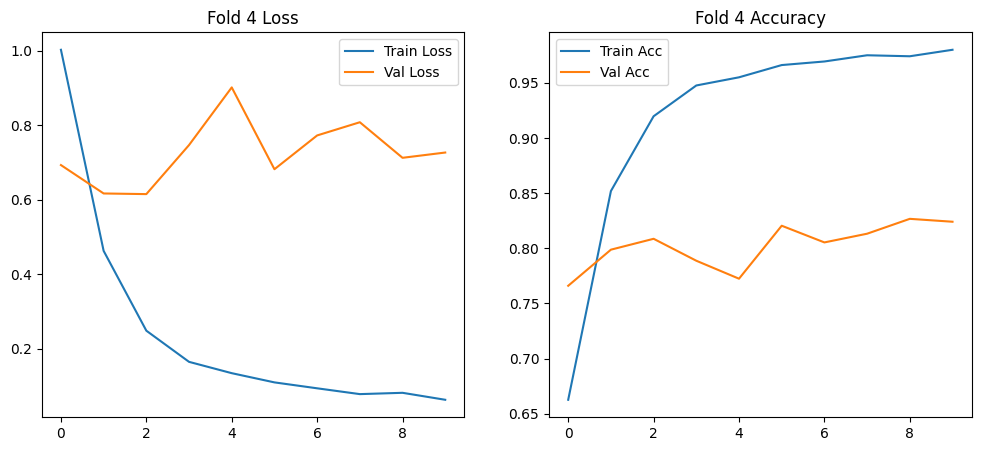

Fold 4 Test Accuracy: 0.8179
Fold data prepared:
- Training: 24326 samples
- Validation: 6082 samples
- Test: 7601 samples


Fold 5 Epoch 1/10: 100%|██████████| 761/761 [09:30<00:00,  1.33it/s]


Epoch 1: Train Loss = 1.0045, Train Acc = 0.6607, Val Loss = 0.7048, Val Acc = 0.7664
Saved best model for Fold 5 at Epoch 1 with Val Acc = 0.7664


Fold 5 Epoch 2/10: 100%|██████████| 761/761 [09:31<00:00,  1.33it/s]


Epoch 2: Train Loss = 0.4602, Train Acc = 0.8494, Val Loss = 0.6213, Val Acc = 0.7984
Saved best model for Fold 5 at Epoch 2 with Val Acc = 0.7984


Fold 5 Epoch 3/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 3: Train Loss = 0.2539, Train Acc = 0.9182, Val Loss = 0.6720, Val Acc = 0.7922


Fold 5 Epoch 4/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 4: Train Loss = 0.1568, Train Acc = 0.9484, Val Loss = 0.8004, Val Acc = 0.7813


Fold 5 Epoch 5/10: 100%|██████████| 761/761 [09:28<00:00,  1.34it/s]


Epoch 5: Train Loss = 0.1335, Train Acc = 0.9562, Val Loss = 0.7625, Val Acc = 0.7930


Fold 5 Epoch 6/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 6: Train Loss = 0.1067, Train Acc = 0.9664, Val Loss = 0.8101, Val Acc = 0.8004
Saved best model for Fold 5 at Epoch 6 with Val Acc = 0.8004


Fold 5 Epoch 7/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 7: Train Loss = 0.0838, Train Acc = 0.9725, Val Loss = 0.8765, Val Acc = 0.7905


Fold 5 Epoch 8/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 8: Train Loss = 0.0915, Train Acc = 0.9707, Val Loss = 0.7248, Val Acc = 0.8144
Saved best model for Fold 5 at Epoch 8 with Val Acc = 0.8144


Fold 5 Epoch 9/10: 100%|██████████| 761/761 [09:29<00:00,  1.34it/s]


Epoch 9: Train Loss = 0.0793, Train Acc = 0.9755, Val Loss = 0.7306, Val Acc = 0.8159
Saved best model for Fold 5 at Epoch 9 with Val Acc = 0.8159


Fold 5 Epoch 10/10: 100%|██████████| 761/761 [09:27<00:00,  1.34it/s]


Epoch 10: Train Loss = 0.0623, Train Acc = 0.9799, Val Loss = 0.7764, Val Acc = 0.8111


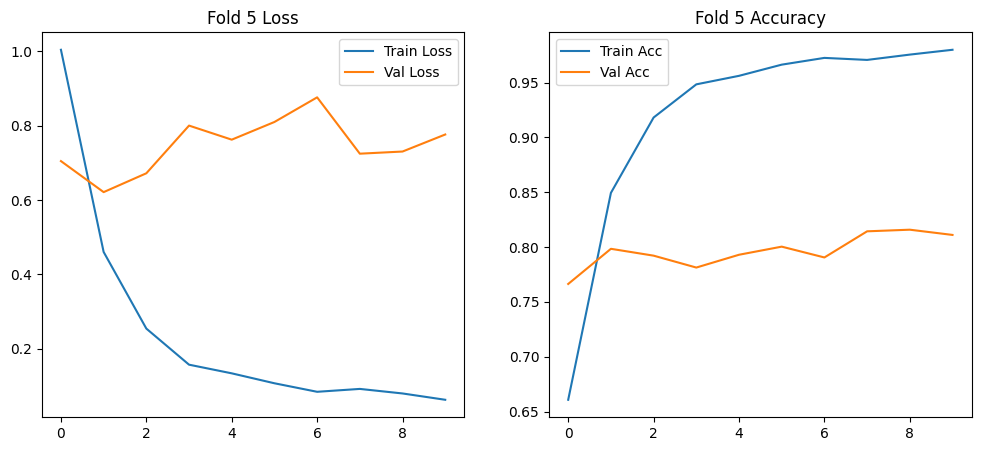

Fold 5 Test Accuracy: 0.8123
Mean Test Accuracy: 0.8157
Best model paths: ['best_models/best_model_fold_1.pth', 'best_models/best_model_fold_2.pth', 'best_models/best_model_fold_3.pth', 'best_models/best_model_fold_4.pth', 'best_models/best_model_fold_5.pth']


In [14]:
# Huấn luyện và đánh giá trên tất cả các fold
def train_with_cross_validation(folds, epochs=10, batch_size=32):
    test_accuracies = []
    best_models = []

    for fold_idx, fold_data in enumerate(folds):
        train_X, train_Y, val_X, val_Y, test_X, test_Y = prepare_fold_data(fold_data)
        test_accuracy, best_model_path = train_and_evaluate_fold(
            fold_idx + 1, train_X, train_Y, val_X, val_Y, test_X, test_Y, epochs=epochs, batch_size=batch_size
        )
        test_accuracies.append(test_accuracy)
        best_models.append(best_model_path)
        print(f"Fold {fold_idx+1} Test Accuracy: {test_accuracy:.4f}")

    # Tính trung bình accuracy
    mean_accuracy = np.mean(test_accuracies)
    print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
    print("Best model paths:", best_models)

# Thực hiện huấn luyện
train_with_cross_validation(folds, epochs=10, batch_size=32)